In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mikolajr7","key":"80a68d8ebeb71c95ad1895a7b0d45e29"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c tensorflow-speech-recognition-challenge

!unzip tensorflow-speech-recognition-challenge.zip -d data
!7z x data/train.7z -odata

!ls /data

Archive:  tensorflow-speech-recognition-challenge.zip
  inflating: data/link_to_gcp_credits_form.txt  
  inflating: data/sample_submission.7z  
  inflating: data/test.7z            
  inflating: data/train.7z           

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1121103842 bytes (1070 MiB)

Extracting archive: data/train.7z
--
Path = data/train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 39 - train/audio/_background_noise_/dude_miaowing.wav                                                            0% 41 - train/audio/_background_noise_/pink_noise.wav

# Load dataset

In [ ]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import Dataset, DataLoader
from transformers import ASTForAudioClassification, AutoProcessor, TFWav2Vec2Model, TFWav2Vec2ForSequenceClassification, Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, Wav2Vec2CTCTokenizer
from transformers.modeling_tf_utils import get_initializer
from tqdm import tqdm

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    tf.random.set_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

torch.use_deterministic_algorithms(True)

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
os.environ['TF_DETERMINISTIC_OPS'] = '1'


In [ ]:
LSTM_RESULTS_DIR = './results/lstm'
os.makedirs(LSTM_RESULTS_DIR, exist_ok=True)

WAV2VEC_RESULTS_DIR = './results/wav2vec'
os.makedirs(WAV2VEC_RESULTS_DIR, exist_ok=True)

AST_RESULTS_DIR = './results/ast'
os.makedirs(AST_RESULTS_DIR, exist_ok=True)

LEARNING_RATES  = [0.01, 0.001, 0.0001]
BATCH_SIZES  = [32, 64]
AUGMENTATION_TYPES = ['None', 'BN', 'TM']
EPOCHS = 10

In [ ]:
def augment_background_noise(audio, noise_level=0.005):
    noise = np.random.randn(len(audio))
    augmented = audio + noise_level * noise
    return augmented / np.max(np.abs(augmented))

def augment_time_mask(audio, mask_size=1600):
    start = np.random.randint(0, len(audio) - mask_size)
    audio[start:start+mask_size] = 0
    return audio

In [ ]:
TRAIN_DATA_DIR = './data/train/audio/'

TARGET_WORDS = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
#TARGET_WORDS = ['yes', 'no', 'off', 'on']
max_files_per_class = 100000
#max_files_per_class = 100

def load_dataset(data_dir, max_files_per_class=max_files_per_class, augmentation_type='None'):
    audio_data = []
    labels = []
    for label in TARGET_WORDS:
        folder_path = os.path.join(data_dir, label)
        if not os.path.isdir(folder_path):
            continue
        files = os.listdir(folder_path)[:max_files_per_class]
        for f in files:
            file_path = os.path.join(folder_path, f)
            try:
                audio, _ = librosa.load(file_path, sr=16000)
                if len(audio) < 16000:
                    audio = np.pad(audio, (0, 16000 - len(audio)))
                else:
                    audio = audio[:16000]

                if augmentation_type == 'BN':
                    audio = augment_background_noise(audio)
                elif augmentation_type == 'TM':
                    audio = augment_time_mask(audio)

                audio_data.append(audio)
                labels.append(label)
            except Exception as e:
                print("Error loading:", file_path)
    return np.array(audio_data), np.array(labels)



In [ ]:
X, y = load_dataset(TRAIN_DATA_DIR, max_files_per_class, 'None')
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

X_train, X_vt, y_train, y_vt = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_vt, y_vt, test_size=0.5, random_state=42)

# Define plots

In [ ]:
def make_learning_curves(history, results_dir, filename_prefix):
    plt.figure(figsize=(10, 5))

    if 'loss' in history.history:
        plt.plot(history.history['loss'], label='Train Loss', linestyle='--')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss', linestyle='--')

    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')

    plt.title(f'{filename_prefix} - Loss & Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{results_dir}/{filename_prefix}_curves.png")
    plt.close()

def make_confussion_matrix(y_true, y_pred, results_dir, filename_prefix):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    import numpy as np

    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    display_cm = np.where(cm < 0.01, "", np.round(cm, 2))

    num_classes = len(TARGET_WORDS)
    figsize = (max(10, num_classes * 0.5), max(8, num_classes * 0.5))

    label_fontsize = 12
    value_fontsize = 8

    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=display_cm,
        fmt='',
        cmap='Blues',
        xticklabels=TARGET_WORDS,
        yticklabels=TARGET_WORDS,
        cbar=True,
        annot_kws={"size": value_fontsize}
    )

    plt.xticks(rotation=90, fontsize=label_fontsize)
    plt.yticks(rotation=0, fontsize=label_fontsize)
    plt.xlabel('Predicted', fontsize=label_fontsize + 2)
    plt.ylabel('True', fontsize=label_fontsize + 2)
    plt.title(filename_prefix, fontsize=label_fontsize + 4)

    plt.tight_layout()
    plt.savefig(f"{results_dir}/{filename_prefix}_confusion.png")
    plt.close()


# Wav2Vec

In [ ]:
class CustomWav2Vec2Classifier(tf.keras.Model):
  def __init__(self, model_name="facebook/wav2vec2-base", num_labels=2):
      super().__init__()
      self.wav2vec2 = TFWav2Vec2Model.from_pretrained(model_name, from_pt=True)
      self.wav2vec2.trainable = False
      self.dropout = tf.keras.layers.Dropout(0.2)
      self.hidden = tf.keras.layers.Dense(128, activation='relu', kernel_initializer=get_initializer(0.02))
      self.classifier = tf.keras.layers.Dense(num_labels, kernel_initializer=get_initializer(0.02))

  def call(self, inputs, training=False):
      input_values = inputs["input_values"]
      attention_mask = inputs.get("attention_mask", None)

      outputs = self.wav2vec2(input_values=input_values, attention_mask=attention_mask, training=False)
      hidden_states = outputs.last_hidden_state
      pooled = tf.reduce_mean(hidden_states, axis=1)

      x = self.dropout(pooled)
      x = self.hidden(x)
      x = self.dropout(x)
      logits = self.classifier(x)
      return logits

In [ ]:
def wav2vec_train_evaluate_model(
        X_train,
        X_valid,
        X_test,
        y_train,
        y_valid,
        y_test,
        learning_rate=0.001,
        batch_size=32,
        epochs = EPOCHS,
        filename_prefix = None
        ):
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

    def preprocess_audio(file_path):
        audio, rate = librosa.load(file_path, sr=16000)
        return audio

    def prepare_dataset(X, y):
        inputs = processor(X, sampling_rate=16000, return_tensors="tf", padding=True, truncation=True, max_length=80000)
        labels = tf.convert_to_tensor(y, dtype=tf.int64)
        return inputs.data, labels

    def create_tf_dataset(X, y, batch_size=batch_size, shuffle=True):
        input_data, labels = prepare_dataset(X, y)
        dataset = tf.data.Dataset.from_tensor_slices((input_data, labels))
        if shuffle:
          dataset = dataset.shuffle(buffer_size=100).batch(batch_size)
        else:
          dataset = dataset.batch(batch_size)
        return dataset

    train_dataset = create_tf_dataset(X_train, y_train)
    val_dataset = create_tf_dataset(X_valid, y_valid)
    test_dataset = create_tf_dataset(X_test, y_test, shuffle=False)

    filename_prefix = f"wav2vec_lr{learning_rate}_bs{batch_size}" if filename_prefix is None else filename_prefix

    wav2vec_model = CustomWav2Vec2Classifier(num_labels=len(TARGET_WORDS))

    wav2vec_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    history = wav2vec_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)
    wav2vec_model.save(f"{WAV2VEC_RESULTS_DIR}/{filename_prefix}.keras")
    make_learning_curves(history, WAV2VEC_RESULTS_DIR, filename_prefix)

    y_true = []
    for _, y in test_dataset:
        y_true.extend(y.numpy())

    logits = wav2vec_model.predict(test_dataset, verbose=0)
    predicted_class = np.argmax(logits, axis=1)
    acc = accuracy_score(y_true, predicted_class)

    make_confussion_matrix(y_true, predicted_class, WAV2VEC_RESULTS_DIR, filename_prefix)

    report = classification_report(y_true, predicted_class, target_names=TARGET_WORDS)
    print(f"Classification Report:\n{report}")
    with open(f"{WAV2VEC_RESULTS_DIR}/{filename_prefix}_report.txt", "w") as f:
        f.write(report)

    report_dict = classification_report(y_true, predicted_class, target_names=TARGET_WORDS, output_dict=True)
    class_accuracies = [report_dict[label]['f1-score'] for label in TARGET_WORDS]

    plt.figure(figsize=(6, 4))
    plt.bar(TARGET_WORDS, class_accuracies, color='lightgreen', edgecolor='black')
    plt.title(f"F1-Score per Class - {filename_prefix}")
    plt.ylim(0, 1)
    plt.ylabel("F1-Score")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f"{WAV2VEC_RESULTS_DIR}/{filename_prefix}_perclass_f1.png")
    plt.show()

    return acc

In [ ]:
wav2vec_hyperparameters_accuracy = []
def wav2vec_hyperparameter_tunning():
    for aug in AUGMENTATION_TYPES:

        X, y = load_dataset(TRAIN_DATA_DIR, max_files_per_class, aug)
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        num_classes = len(le.classes_)
        X_train, X_vt, y_train, y_vt = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
        X_valid, X_test, y_valid, y_test = train_test_split(X_vt, y_vt, test_size=0.5, random_state=42)

        for lr in LEARNING_RATES:
            for bs in BATCH_SIZES:
                filename_prefix = f"wav2_lr{lr}_bs{bs}_aug{aug}"
                acc = wav2vec_train_evaluate_model(
                    X_train,
                    X_valid,
                    X_test,
                    y_train,
                    y_valid,
                    y_test,
                    learning_rate=lr,
                    batch_size=bs,
                    epochs = EPOCHS,
                    filename_prefix = filename_prefix
                    )
                wav2vec_hyperparameters_accuracy.append([lr, bs, aug, acc])
    wav2vec_hyperparameters_accuracy_df = pd.DataFrame(wav2vec_hyperparameters_accuracy, columns=["learning_rate", "batch_size", "augmentation", "accuracy"])
    wav2vec_hyperparameters_accuracy_df.to_csv(f"{WAV2VEC_RESULTS_DIR}/wav2vec_accuracy.csv")
    return wav2vec_hyperparameters_accuracy_df


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(

TFWav2Vec2Model has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFWav2Vec2Model: ['quantizer.weight_proj.weight', 'quantizer.weight_proj.bias', 'project_hid.weight', 'quantizer.codevectors', 'project_q.bias', 'project_hid.bias', 'project_q.weight']
- This IS expected if you are initializing TFWav2Vec2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a Bert

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1416/1416 ━━━━━━━━━━━━━━━━━━━━ 89s 49ms/step - accuracy: 0.2948 - loss: 2.4254 - val_accuracy: 0.7354 - val_loss: 1.0459
Epoch 2/10
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 65s 46ms/step - accuracy: 0.6449 - loss: 1.2011 - val_accuracy: 0.8040 - val_loss: 0.7519
Epoch 3/10
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 65s 46ms/step - accuracy: 0.7020 - loss: 1.0102 - val_accuracy: 0.8381 - val_loss: 0.6331
Epoch 4/10
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 65s 46ms/step - accuracy: 0.7255 - loss: 0.9239 - val_accuracy: 0.8434 - val_loss: 0.5805
Epoch 5/10
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 64s 45ms/step - accuracy: 0.7429 - loss: 0.8629 - val_accuracy: 0.8511 - val_loss: 0.5421
Epoch 6/10
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 64s 45ms/step - accuracy: 0.7437 - loss: 0.8489 - val_accuracy: 0.8566 - val_loss: 0.5352
Epoch 7/10
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 65s 46ms/step - accuracy: 0.7537 - loss: 0.8236 - val_accuracy: 0.8591 - val_loss: 0.5198
Epoch 8/10
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 65s 46ms/step - accuracy: 0.7548 - loss: 0.81

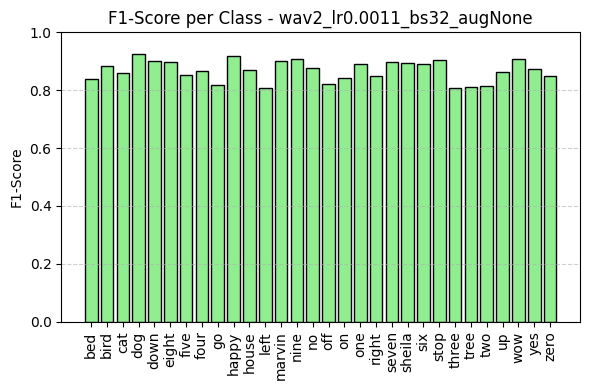

,learning_rate,batch_size,augmentation,accuracy
0,0.0011,32,None,0.866722


In [ ]:
LEARNING_RATES  = [0.0011]
BATCH_SIZES  = [32]
AUGMENTATION_TYPES = ['None']

wav2vec_hyperparameters_acc_df = wav2vec_hyperparameter_tunning()
wav2vec_hyperparameters_acc_df.head(10)

# AST


In [ ]:
class AudioDataset(Dataset):
    def __init__(self, waveforms, labels, processor):
        self.waveforms = waveforms
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.waveforms)

    def __getitem__(self, idx):
        audio = self.waveforms[idx]
        inputs = self.processor(
            audio,
            sampling_rate=16000,
            return_tensors="pt",
            padding=True,
            truncation=True
        )
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return inputs, label

In [ ]:
def ast_train_evaluate_model(
    X_train, X_valid, X_test, y_train, y_valid, y_test,
    learning_rate=2e-5,
    batch_size=4,
    epochs=10,
    filename_prefix=None
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
    processor = AutoProcessor.from_pretrained(model_name)

    filename_prefix = f"ast_lr{learning_rate}_bs{batch_size}" if filename_prefix is None else filename_prefix

    train_dataset = AudioDataset(X_train, y_train, processor)
    valid_dataset = AudioDataset(X_valid, y_valid, processor)
    test_dataset  = AudioDataset(X_test,  y_test,  processor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size)

    model = ASTForAudioClassification.from_pretrained(
        model_name,
        num_labels=len(TARGET_WORDS),
        ignore_mismatched_sizes=True
    ).to(device)

    for name, param in model.named_parameters():
        if "classifier" not in name:
            param.requires_grad = False

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in valid_loader:
                inputs, labels = batch
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)

                outputs = model(**inputs)
                preds = torch.argmax(outputs.logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        train_losses.append(total_loss / len(train_loader))
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Acc = {val_acc:.4f}")
        if torch.cuda.is_available():
            print(f"[GPU] Allocated: {torch.cuda.memory_allocated() / 1e6:.2f} MB")

        torch.cuda.empty_cache()

    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)
    print(f"Test Accuracy: {test_acc:.4f}")

    class HistoryWrapper:
        def __init__(self, history_dict):
            self.history = history_dict

    history = HistoryWrapper({
        "accuracy": val_accuracies,
        "val_accuracy": val_accuracies,
        "loss": train_losses,
    })

    # torch.save(model.state_dict(), f"{AST_RESULTS_DIR}/{filename_prefix}.pt")
    make_learning_curves(history, AST_RESULTS_DIR, filename_prefix)
    make_confussion_matrix(test_labels, test_preds, AST_RESULTS_DIR, filename_prefix)

    report = classification_report(test_labels, test_preds, target_names=TARGET_WORDS)
    print(f"Classification Report:\n{report}")
    with open(f"{AST_RESULTS_DIR}/{filename_prefix}_report.txt", "w") as f:
        f.write(report)

    report_dict = classification_report(test_labels, test_preds, target_names=TARGET_WORDS, output_dict=True)
    class_accuracies = [report_dict[label]['f1-score'] for label in TARGET_WORDS]

    plt.figure(figsize=(6, 4))
    plt.bar(TARGET_WORDS, class_accuracies, color='lightcoral', edgecolor='black')
    plt.title(f"F1-Score per Class - {filename_prefix}")
    plt.ylim(0, 1)
    plt.ylabel("F1-Score")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f"{AST_RESULTS_DIR}/{filename_prefix}_perclass_f1.png")
    plt.show()

    return test_acc


In [ ]:
ast_hyperparameters_accuracy = []
def ast_hyperparameter_tunning():
    for aug in AUGMENTATION_TYPES:

        X, y = load_dataset(TRAIN_DATA_DIR, max_files_per_class, aug)
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        num_classes = len(le.classes_)
        X_train, X_vt, y_train, y_vt = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
        X_valid, X_test, y_valid, y_test = train_test_split(X_vt, y_vt, test_size=0.5, random_state=42)

        for lr in LEARNING_RATES:
            for bs in BATCH_SIZES:
                filename_prefix = f"ast_lr{lr}_bs{bs}_aug{aug}"
                acc = ast_train_evaluate_model(
                    X_train,
                    X_valid,
                    X_test,
                    y_train,
                    y_valid,
                    y_test,
                    learning_rate=lr,
                    batch_size=bs,
                    epochs = EPOCHS,
                    filename_prefix = filename_prefix
                    )
                ast_hyperparameters_accuracy.append([lr, bs, aug, acc])
    ast_hyperparameters_accuracy_df = pd.DataFrame(ast_hyperparameters_accuracy, columns=["learning_rate", "batch_size", "augmentation", "accuracy"])
    ast_hyperparameters_accuracy_df.to_csv(f"{AST_RESULTS_DIR}/ast_accuracy.csv")
    return ast_hyperparameters_accuracy_df


Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([30]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([30, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10: 100%|██████████| 708/708 [12:39<00:00,  1.07s/it]


Epoch 1: Train Loss = 1.8143, Val Acc = 0.6117
[GPU] Allocated: 436.06 MB


Epoch 2/10: 100%|██████████| 708/708 [12:39<00:00,  1.07s/it]


Epoch 2: Train Loss = 1.2788, Val Acc = 0.6407
[GPU] Allocated: 436.06 MB


Epoch 3/10: 100%|██████████| 708/708 [12:39<00:00,  1.07s/it]


Epoch 3: Train Loss = 1.1838, Val Acc = 0.6542
[GPU] Allocated: 436.06 MB


Epoch 4/10: 100%|██████████| 708/708 [12:39<00:00,  1.07s/it]


Epoch 4: Train Loss = 1.1318, Val Acc = 0.6573
[GPU] Allocated: 436.06 MB


Epoch 5/10: 100%|██████████| 708/708 [12:39<00:00,  1.07s/it]


Epoch 5: Train Loss = 1.1035, Val Acc = 0.6707
[GPU] Allocated: 436.06 MB


Epoch 6/10: 100%|██████████| 708/708 [12:39<00:00,  1.07s/it]


Epoch 6: Train Loss = 1.0813, Val Acc = 0.6681
[GPU] Allocated: 436.06 MB


Epoch 7/10: 100%|██████████| 708/708 [12:39<00:00,  1.07s/it]


Epoch 7: Train Loss = 1.0684, Val Acc = 0.6650
[GPU] Allocated: 436.06 MB


Epoch 8/10: 100%|██████████| 708/708 [12:38<00:00,  1.07s/it]


Epoch 8: Train Loss = 1.0483, Val Acc = 0.6566
[GPU] Allocated: 436.06 MB


Epoch 9/10: 100%|██████████| 708/708 [12:39<00:00,  1.07s/it]


Epoch 9: Train Loss = 1.0552, Val Acc = 0.6662
[GPU] Allocated: 436.06 MB


Epoch 10/10: 100%|██████████| 708/708 [12:38<00:00,  1.07s/it]


Epoch 10: Train Loss = 1.0336, Val Acc = 0.6738
[GPU] Allocated: 436.06 MB
Test Accuracy: 0.6693
Classification Report:
              precision    recall  f1-score   support

         bed       0.43      0.61      0.51       280
        bird       0.59      0.50      0.54       276
         cat       0.72      0.58      0.64       266
         dog       0.65      0.40      0.49       281
        down       0.46      0.78      0.58       385
       eight       0.72      0.81      0.77       329
        five       0.61      0.58      0.59       341
        four       0.79      0.51      0.62       333
          go       0.54      0.37      0.43       347
       happy       0.79      0.79      0.79       247
       house       0.66      0.82      0.73       259
        left       0.70      0.66      0.68       324
      marvin       0.72      0.73      0.72       264
        nine       0.58      0.74      0.65       363
          no       0.54      0.61      0.57       368
         off   

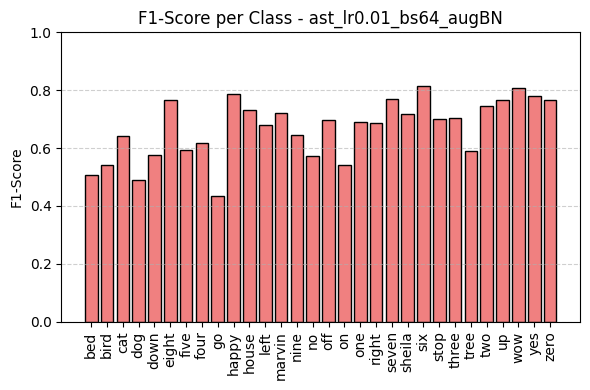

,learning_rate,batch_size,augmentation,accuracy
0,0.01,64,BN,0.669276


In [ ]:
LEARNING_RATES  = [0.01]
BATCH_SIZES  = [64]
AUGMENTATION_TYPES = ['BN']

ast_hyperparameters_acc_df = ast_hyperparameter_tunning()
ast_hyperparameters_acc_df.head(10)

# LSTM

In [ ]:
def extract_mfcc(audio):
    mfcc = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
    return mfcc.T

In [ ]:
def lstm_train_evaluate_model(
        X_mfcc,
        X_mfcc_valid,
        X_mfcc_test,
        y_train,
        y_valid,
        y_test,
        learning_rate=0.001,
        batch_size=32,
        epochs = EPOCHS,
        filename_prefix = None
        ):

    filename_prefix = f"lstm_lr{learning_rate}_bs{batch_size}" if filename_prefix is None else filename_prefix

    lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(100, 40)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    lstm_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = lstm_model.fit(X_mfcc, y_train, validation_data=(X_mfcc_valid, y_valid), epochs=epochs, batch_size=batch_size)

    lstm_model.save(f"{LSTM_RESULTS_DIR}/{filename_prefix}.keras")
    make_learning_curves(history, LSTM_RESULTS_DIR, filename_prefix)

    preds = lstm_model.predict(X_mfcc_test, verbose=0)
    predicted_class = np.argmax(preds, axis=1)
    acc = accuracy_score(y_test, predicted_class)
    make_confussion_matrix(y_test, predicted_class, LSTM_RESULTS_DIR, filename_prefix)

    report = classification_report(y_test, predicted_class, target_names=TARGET_WORDS)
    print(f"Classification Report:\n{report}")
    with open(f"{LSTM_RESULTS_DIR}/{filename_prefix}_report.txt", "w") as f:
        f.write(report)

    report_dict = classification_report(y_test, predicted_class, target_names=TARGET_WORDS, output_dict=True)
    class_accuracies = [report_dict[label]['f1-score'] for label in TARGET_WORDS]

    plt.figure(figsize=(6, 4))
    plt.bar(TARGET_WORDS, class_accuracies, color='skyblue', edgecolor='black')
    plt.title(f"F1-Score per Class - {filename_prefix}")
    plt.ylim(0, 1)
    plt.ylabel("F1-Score")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f"{LSTM_RESULTS_DIR}/{filename_prefix}_perclass_f1.png")
    plt.show()

    return acc



In [ ]:
lstm_hyperparameters_accuracy = []
def lstm_hyperparameter_tunning():
    for aug in AUGMENTATION_TYPES:

        X, y = load_dataset(TRAIN_DATA_DIR, max_files_per_class, aug)
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        num_classes = len(le.classes_)
        X_train, X_vt, y_train, y_vt = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
        X_valid, X_test, y_valid, y_test = train_test_split(X_vt, y_vt, test_size=0.5, random_state=42)

        X_mfcc = np.array([extract_mfcc(x) for x in X_train])
        X_mfcc_valid = np.array([extract_mfcc(x) for x in X_valid])
        X_mfcc_test = np.array([extract_mfcc(x) for x in X_test])

        X_mfcc = pad_sequences(X_mfcc, maxlen=100, dtype='float32', padding='post')
        X_mfcc_valid = pad_sequences(X_mfcc_valid, maxlen=100, dtype='float32', padding='post')
        X_mfcc_test = pad_sequences(X_mfcc_test, maxlen=100, dtype='float32', padding='post')

        for lr in LEARNING_RATES:
            for bs in BATCH_SIZES:
                filename_prefix = f"lstm_lr{lr}_bs{bs}_aug{aug}"
                acc = lstm_train_evaluate_model(
                    X_mfcc,
                    X_mfcc_valid,
                    X_mfcc_test,
                    y_train,
                    y_valid,
                    y_test,
                    learning_rate=lr,
                    batch_size=bs,
                    epochs = EPOCHS,
                    filename_prefix = filename_prefix
                    )
                lstm_hyperparameters_accuracy.append([lr, bs, aug, acc])
    lstm_hyperparameters_accuracy_df = pd.DataFrame(lstm_hyperparameters_accuracy, columns=["learning_rate", "batch_size", "augmentation", "accuracy"])
    lstm_hyperparameters_accuracy_df.to_csv(f"{LSTM_RESULTS_DIR}/lstm_accuracy.csv")
    return lstm_hyperparameters_accuracy_df


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
708/708 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.0769 - loss: 3.1202 - val_accuracy: 0.1903 - val_loss: 2.5419
Epoch 2/10
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2398 - loss: 2.3502 - val_accuracy: 0.3905 - val_loss: 1.9178
Epoch 3/10
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4395 - loss: 1.7607 - val_accuracy: 0.5485 - val_loss: 1.4781
Epoch 4/10
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5813 - loss: 1.3484 - val_accuracy: 0.6241 - val_loss: 1.2194
Epoch 5/10
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6675 - loss: 1.0815 - val_accuracy: 0.7060 - val_loss: 0.9701
Epoch 6/10
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7309 - loss: 0.8908 - val_accuracy: 0.7511 - val_loss: 0.8379
Epoch 7/10
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7691 - loss: 0.7658 - val_accuracy: 0.7764 - val_loss: 0.7605
Epoch 8/10
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7928 - loss: 0.6826 - val_accuracy: 0.

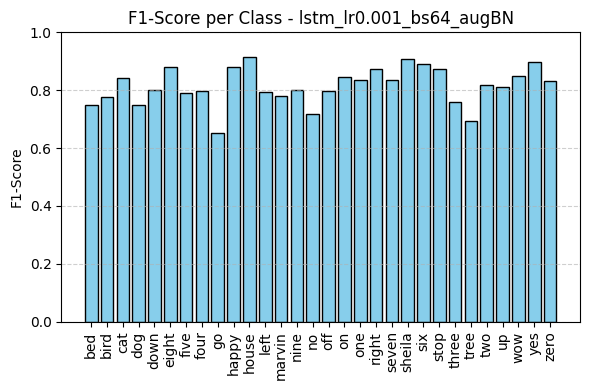

,learning_rate,batch_size,augmentation,accuracy
0,0.001,64,BN,0.81306


In [ ]:
LEARNING_RATES  = [0.001]
BATCH_SIZES  = [64]
AUGMENTATION_TYPES = ['BN']

lstm_hyperparameters_acc_df = lstm_hyperparameter_tunning()
lstm_hyperparameters_acc_df.head(10)

# Wykresy końcowe

Najlepsze konfiguracje dla każdego modelu:


<ipython-input-65-31d870283a2f>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_per_model = combined_df.groupby('model').apply(lambda df: df.loc[df['accuracy'].idxmax()]).reset_index(drop=True)


,model,learning_rate,batch_size,augmentation,accuracy
0,AST,0.0100,64,BN,0.669276
1,LSTM,0.0010,64,BN,0.813060
2,Wav2Vec2,0.0011,32,NaN,0.866722


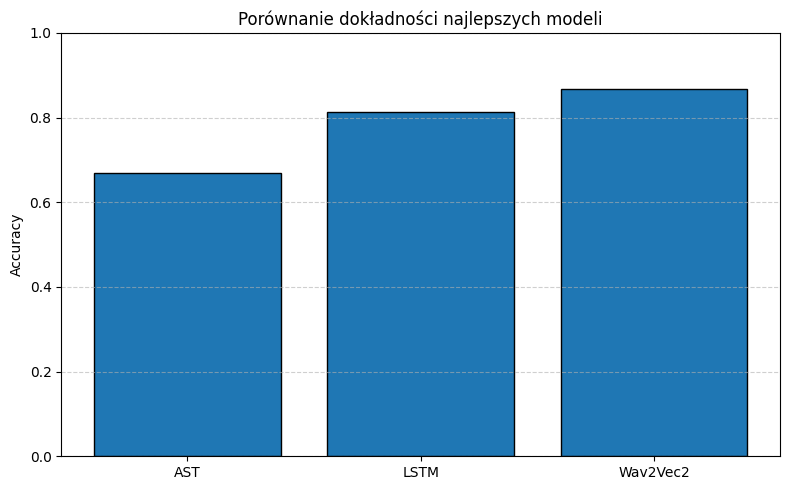

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

lstm_df = pd.read_csv('./results/lstm/lstm_accuracy.csv')
wav2vec_df = pd.read_csv('./results/wav2vec/wav2vec_accuracy.csv')
ast_df = pd.read_csv('./results/ast/ast_accuracy.csv')

lstm_df['model'] = 'LSTM'
wav2vec_df['model'] = 'Wav2Vec2'
ast_df['model'] = 'AST'

combined_df = pd.concat([lstm_df, wav2vec_df, ast_df], ignore_index=True)

best_per_model = combined_df.groupby('model').apply(lambda df: df.loc[df['accuracy'].idxmax()]).reset_index(drop=True)

print("Najlepsze konfiguracje dla każdego modelu:")
display(best_per_model[['model', 'learning_rate', 'batch_size', 'augmentation', 'accuracy']])

best_per_model.to_csv('./results/best_models_summary.csv', index=False)

plt.figure(figsize=(8, 5))
plt.bar(best_per_model['model'], best_per_model['accuracy'], edgecolor='black')
plt.ylim(0, 1)
plt.title('Porównanie dokładności najlepszych modeli')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig('./results/best_models_accuracy.png')
plt.show()


In [ ]:
import shutil
from google.colab import files

shutil.make_archive("results_backup", 'zip', "results")

files.download("results_backup.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>